### This is the version with trace + title + processed text

In [5]:
import os
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
import seaborn as sns



nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Haochen_Wang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Haochen_Wang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Gets the current working directory
current_directory = os.getcwd()

# Set a relative path
relative_path = os.path.join(os.pardir, os.pardir, "Dataset PPT Report", "Metadata Labeled.csv")

# Use os.path.join to combine the current directory with a relative path to create a complete file path
full_path = os.path.join(current_directory, relative_path)

# Read CSV file
data = pd.read_csv(full_path)

In [8]:
##input data
#data = pd.read_csv("Metadata Labeled.csv")
data['Trace'] = data['Trace'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).strip())
data['Title'] = data['Title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).strip())

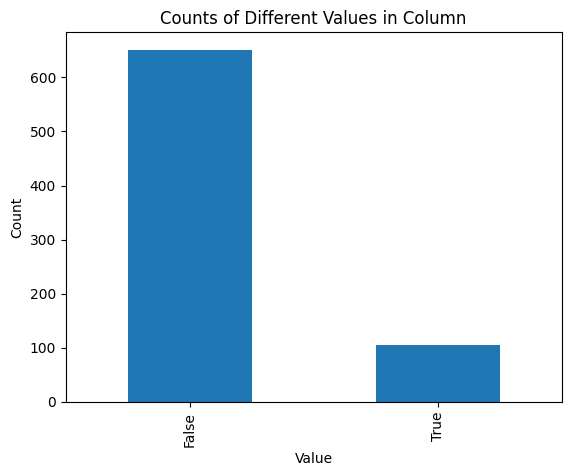

In [9]:
# imblance
column_data = data['Good']

value_counts = column_data.value_counts()

value_counts.plot(kind='bar')

plt.title('Counts of Different Values in Column')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [9]:
# define lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)])

In [10]:
data['Trace'] = data['Trace'].apply(lemmatize_text)
data['Title'] = data['Title'].apply(lemmatize_text)
data['Processed Text'] = data['Processed Text'].apply(lemmatize_text)

In [11]:
X = data[['Trace', 'Title', 'Processed Text']]
y = data.Good

In [12]:
class ThresholdKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, threshold=0.5, **kwargs):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.p = p
        self.metric = metric
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.threshold = threshold
        self.kwargs = kwargs

    def fit(self, X, y):
        self.knn_ = KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, algorithm=self.algorithm, leaf_size=self.leaf_size, p=self.p, metric=self.metric, metric_params=self.metric_params, n_jobs=self.n_jobs, **self.kwargs)
        self.knn_.fit(X, y)
        return self

    def predict(self, X):
        probabilities = self.knn_.predict_proba(X)
        return (probabilities[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.knn_.predict_proba(X)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [13]:
# 80% train set, 20% test set with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12,stratify=y)

In [14]:
# define pipeline
knn_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('vect_trace', CountVectorizer(), 'Trace'),
        ('vect_title', CountVectorizer(), 'Title'),
        ('vect_contents', CountVectorizer(), 'Processed Text'),
    ])),
    ('tfidf', TfidfTransformer()),
    ('clf', ThresholdKNeighborsClassifier())
])

In [15]:
# hyperparameters
parameters = {
    'preprocessor__vect_trace__ngram_range': [(1, 1), (1, 2)],
    'preprocessor__vect_title__ngram_range': [(1, 1), (1, 2)],
    'preprocessor__vect_contents__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__n_neighbors': [3,5,7,10],
    'clf__threshold': [0.3, 0.4, 0.5, 0.6, 0.7],
}

In [16]:
# cross validation
grid_search = GridSearchCV(knn_pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best parameters found: {'clf__n_neighbors': 7, 'clf__threshold': 0.5, 'preprocessor__vect_contents__ngram_range': (1, 2), 'preprocessor__vect_title__ngram_range': (1, 1), 'preprocessor__vect_trace__ngram_range': (1, 2), 'tfidf__use_idf': True}


In [17]:
y_pred_test = grid_search.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred_test))
print("Test set precision:", precision_score(y_test, y_pred_test))
print("Test set recall:", recall_score(y_test, y_pred_test))
print("Test set F1 score:", f1_score(y_test, y_pred_test))

Test set accuracy: 0.9736842105263158
Test set precision: 0.9473684210526315
Test set recall: 0.8571428571428571
Test set F1 score: 0.9


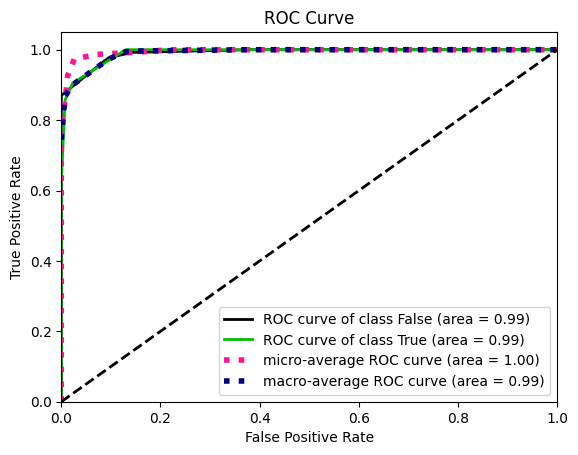

In [18]:
y_pred_proba_test = grid_search.predict_proba(X_test)

# ROC CURVE
skplt.metrics.plot_roc(y_test, y_pred_proba_test)
plt.title('ROC Curve')
plt.show()

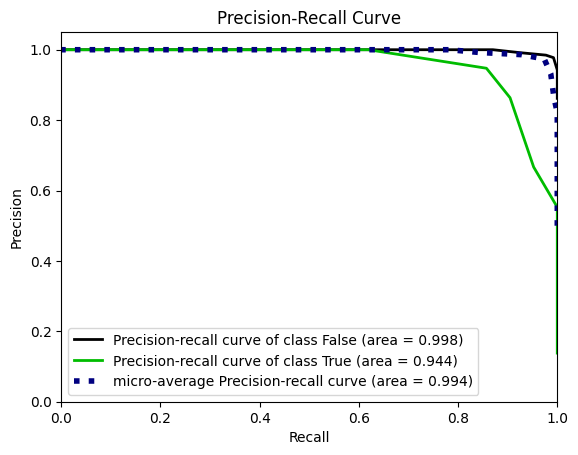

In [19]:
# Precision-Recall CURVE
skplt.metrics.plot_precision_recall(y_test, y_pred_proba_test)
plt.title('Precision-Recall Curve')
plt.show()

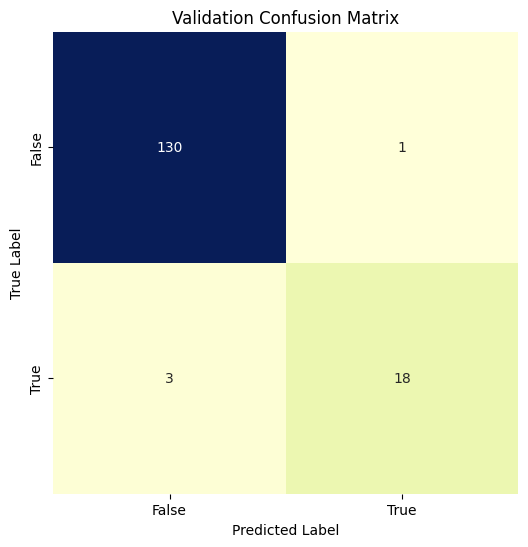

In [20]:
# validation confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False, xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()